In [159]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
from skimage import measure
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
from datetime import datetime as dt

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

## current script object
thismodule = sys.modules[__name__]

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

Own modules available: ['casestudy', 'conditionalstats', 'conditionalstats_chunked', 'plot1D', 'plot2D', 'plotCondPDFs']
Own modules available: ['load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF', 'fcns_load_RCEMIP_SAM', 'fcns_multiscale_extremes', 'PrecipGrid', 'fcns_load_DYAMOND_SAM']


In [4]:
import conditionalstats as cs
from fcns_multiscale_extremes import *
from plot2D import *

In [5]:
region = 'tropics'
path_regrid = os.path.join(DIR_DYAMOND_PROCESSED,region,'SAM','regridded')

In [6]:
figdir = os.path.join(os.path.dirname(workdir),'figures/multiscale_extremes',region)
os.makedirs(figdir,exist_ok=True)

In [7]:
prec_data = xr.open_dataset(os.path.join(path_regrid,'Prec.nc'))

In [8]:
prec_data

<xarray.Dataset>
Dimensions:            (days: 22, lat: 1554, lat_global: 60, lon: 9216, lon_global: 360)
Coordinates:
  * lat                (lat) float32 -30.0 -29.96 -29.92 ... 29.92 29.96 30.0
  * lon                (lon) float32 0.01953 0.05859 0.09766 ... 359.9 360.0
  * lat_global         (lat_global) int64 0 1 2 3 4 5 6 ... 53 54 55 56 57 58 59
  * lon_global         (lon_global) int64 0 1 2 3 4 5 ... 355 356 357 358 359
  * days               (days) int64 0 1 2 3 4 5 6 7 ... 14 15 16 17 18 19 20 21
Data variables:
    pixel_surf         (lat, lon) float64 ...
    global_pixel_surf  (lat_global, lon_global) float64 ...
    mean_Prec          (lat_global, lon_global, days) float64 ...
    max_Prec           (lat_global, lon_global, days) float64 ...

In [9]:
dim_t = 2

In [13]:
# Single-variable distributions
mean_prec = prec_data.mean_Prec.values
dist_mean_prec = cs.Distribution(name="DYAMOND mean precipitation", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_mean_prec.computeDistribution(sample = mean_prec)
dist_mean_prec.storeBinLocations(sample = mean_prec,sizemax=1000)

max_prec = prec_data.max_Prec.values
dist_max_prec = cs.Distribution(name="DYAMOND max precipitation", bintype = "invlogQ", nd = 5, fill_last_decade=True)
dist_max_prec.computeDistribution(sample = max_prec)
dist_max_prec.storeBinLocations(sample = max_prec,sizemax=1000)

# Joint distribution
jdist_prec = cs.JointDistribution(name='Prec mean vs. max',distribution1=dist_mean_prec, distribution2=dist_max_prec)
jdist_prec.computeDistribution(sample1=mean_prec,sample2=max_prec)
jdist_prec.computeNormalizedDensity(sample1=mean_prec,sample2=max_prec)
digit3D_mean, digit3D_max = jdist_prec.computeConditionalLocations(sample1=mean_prec,sample2=max_prec)

In [14]:
def jointDigit(digit3D_1,digit3D_2):
    
    digit3D_joint = 100*digit3D_1 + digit3D_2
    
    return digit3D_joint

digit3D_joint = jointDigit(digit3D_mean,digit3D_max)

In [15]:
# indices/digits in joint distribution space
dig_1D = np.digitize(dist_max_prec.ranks,dist_max_prec.ranks)
dig_2D_i, dig_2D_j = np.meshgrid(dig_1D,dig_1D)
dig_2D = jointDigit(*np.meshgrid(dig_1D,dig_1D))

In [16]:
#-- create masks for a region on joint distribution
# mask a square over 90th percentile
mask_jdist_90_90 = np.outer(dist_mean_prec.ranks >= 90,dist_max_prec.ranks >= 90)
mask_jdist_90_0 = np.outer(dist_mean_prec.ranks >= 90,dist_max_prec.ranks >= 0)
mask_jdist_0_90 = np.outer(dist_mean_prec.ranks >= 0,dist_max_prec.ranks >= 90)
mask_jdist_below_90 = np.outer(dist_mean_prec.ranks < 90,dist_max_prec.ranks < 90)
# mask above diagonal
mask_lower_diag = dig_2D_i <= dig_2D_j
mask_upper_diag = dig_2D_i > dig_2D_j
# mask correlated and anticorrelated
Z_norm = jdist_prec.norm_density
Z_count = jdist_prec.bincount
mask_corr = Z_norm > 1
mask_anticorr = np.logical_and(Z_norm < 1,Z_count>0)
# mask left of branch 1
mask_branch1 = np.logical_and(mask_upper_diag,mask_anticorr)
mask_branch1_90 = np.logical_and(mask_branch1,mask_jdist_0_90)
# mask below to branch 2
mask_branch2 = np.logical_and(mask_lower_diag,mask_anticorr)
mask_branch2_90 = np.logical_and(mask_branch2,mask_jdist_90_0)
# mask_middle, upper and lower diagonal
mask_coloc_c = np.logical_and(mask_upper_diag,mask_corr)
mask_coloc_c_90 = np.logical_and(mask_coloc_c,mask_jdist_0_90)
mask_coloc_ac = np.logical_and(mask_lower_diag,mask_corr)
mask_coloc_ac_90 = np.logical_and(mask_coloc_ac,mask_jdist_90_0)

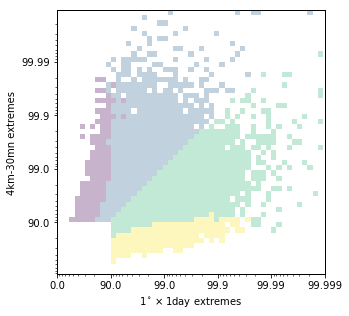

In [45]:
# create mask

mask_show = 1.*mask_branch1_90 + 2.*mask_coloc_c_90 + 3.*mask_coloc_ac_90 + 4.*mask_branch2_90
mask_show[mask_show == 0] = np.nan

# Show

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4.8,4.85))

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax_show.imshow(mask_show.T,alpha=0.3,origin='lower')

ax_show.set_xticks([])
ax_show.set_yticks([])

plt.savefig(os.path.join(figdir,'Y_branches_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')

/Users/bfildier/Code/analyses/explore-multiscale-extremes/functions/fcns_multiscale_extremes.py:11: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


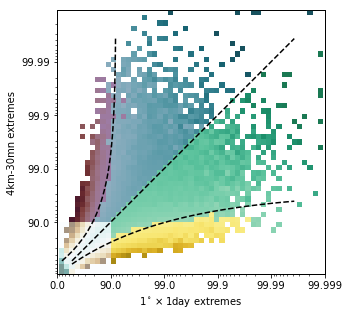

In [46]:
# Show normalized density with branches fitted -- black

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4.8,4.85))

Z = jdist_prec.norm_density.T

title = 'Normalized density'
scale ='log'
vbds = (1e-3,1e3)
cmap = plt.cm.BrBG

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
# ax.set_title(title)

# -- Density
pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
cont = measure.find_contours(Z, 1)

# -- Masks multiscale categories
mask_categories = mask_show = 1.*mask_branch1_90 + 2.*mask_coloc_c_90 + 3.*mask_coloc_ac_90 + 4.*mask_branch2_90
mask_categories[mask_categories==0] = np.nan
ax_show.imshow(mask_categories.T,alpha=0.5,origin='lower')

# cornoer below 90th percentile
ma_no_ext = np.ma.masked_where(mask_jdist_below_90 == 0, mask_jdist_below_90)
ax_show.imshow(ma_no_ext.T,alpha=0.5,origin='lower',cmap='Blues')

# -- Branches
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show branches
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

# show 1-1 line
ax_show.plot(x_branch_2,x_branch_2,'k--')

# cb = fig.colorbar(pcm, ax=ax_show)
# # cb.set_label('Normalized density')
# cb.set_label('Less colocated     -----     More colocated\n than random')

plt.savefig(os.path.join(figdir,'norm_density_w_masks_on_max_vs_mean_prec_extremes_Y_branches.pdf'),bbox_inches='tight')

In [17]:
# for any bin, find set of x,y,t points
def get_mask_yxt(digit_1,digit_2,digit3D_1,digit3D_2):
    
    dj = jointDigit(digit_1,digit_2)
    dj_3D = jointDigit(digit3D_1,digit3D_2)
    
    return dj_3D == dj

# for a full joint-dist mask, find set of x,y,t points
def get_mask_yxt_from_mask_jdist(mask_jdist,digits3D_1,digits3D_2):
    """For each joint extreme in bin (i,j), return mask in the spatiotemporal domain."""
    
    mask_yxt_all = False
    i_j_mask = np.where(mask_jdist)
    for i,j in zip(i_j_mask[0],i_j_mask[1]):
        
        mask_yxt = get_mask_yxt(i,j,digits3D_1,digits3D_2)
        mask_yxt_all = np.logical_or(mask_yxt_all,mask_yxt)
    
    return mask_yxt_all

def getCoordValues(data,coordname):
    
    xname = coordname

    x_native = data[xname].values
    x_bnds = np.round(x_native[0],2), np.round(x_native[-1],2)
    x_regrid = data['%s_global'%xname].values
    Nx = len(x_regrid)
    
    dx = np.diff(x_bnds)/Nx

    edges = np.arange(x_bnds[0],x_bnds[1]+dx,dx)
    centers = np.convolve(edges,[0.5,0.5],'valid')

    return centers

def getCoords2D(dataset,slice_lon,slice_lat):
    
    
    # extract coordinates
    lat_1D = getCoordValues(dataset,'lat')
    lon_1D = getCoordValues(dataset,'lon')

    # compute 2D meshgrid of coordinates
    lonarray,latarray = np.meshgrid(lon_1D,lat_1D)
    
    return lonarray,latarray


# test 1 joint bin
mask_yxt_20_30 = get_mask_yxt(20,30,digit3D_mean,digit3D_max)
count_yxt_20_30 = np.sum(mask_yxt_20_30,axis=dim_t)

# plt.imshow(count_tyz_20_30.T)

# test 90-90 mask
mask_yxt_90_90 = get_mask_yxt_from_mask_jdist(mask_jdist_90_90,digit3D_mean,digit3D_max)
count_yxt_90_90 = np.sum(mask_yxt_90_90,axis=dim_t)

In [18]:
## image
# cmap = plt.cm.bone_r
# cmap = plt.cm.Blues
cmap = plt.cm.afmhot_r
# cmap_mcs = plt.cm.get_cmap('rainbow', 10)
cmap_mcs = plt.cm.get_cmap('Accent', 10)
# clim = (10,70)
lon_lim = (0,360)
lat_lim = (-30,30)
slice_lat = slice(*lat_lim)
slice_lon = slice(*lon_lim)

# compute figure size
dlon = np.diff(lon_lim)[0] % 360
if dlon == 0: dlon = 360
dlat = np.diff(lat_lim)[0]
Lx_fig = 15
Lx_cbar = 1.5
Ly_title = 1
Ly_fig = (Lx_fig-Lx_cbar)/dlon*dlat + Ly_title
print('figure size =',Lx_fig,Ly_fig)

def makeMap(mask_yxt):

    # initialize figure
    fig = plt.figure(figsize=(Lx_fig,Ly_fig))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

    # coords
    lonarray_dyamond,latarray_dyamond = getCoords2D(prec_data,slice_lon,slice_lat)            
    # data
    Z = np.sum(mask_yxt,axis=dim_t) # count
    Next = np.sum(Z)
    # show
    # im = ax.pcolormesh(np.ravel(lonarray_dyamond),np.ravel(latarray_dyamond),np.ravel(Z),transform=ccrs.PlateCarree(),alpha=0.9,cmap=cmap)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        im = ax.pcolormesh(lonarray_dyamond,latarray_dyamond,Z,transform=ccrs.PlateCarree(),alpha=0.9,cmap=cmap)
    # im.set_clim(*clim)

    ax.coastlines('110m')
    ax.gridlines()
    ax.text(0.01,0.05,"N = %d"%Next,transform=ax.transAxes)
    
    # Colorbar
    x,y,w,h = ax.get_position().bounds
    dx = w/60
    cax = plt.axes([x+w+1.5*dx,y,dx,h])
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel('Bincount (#)')

    return ax

figure size = 15 3.25


Convective only
Mostly convective
Mostly mesoscale
Mesoscale only


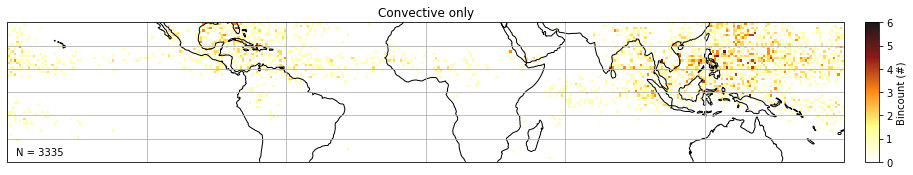

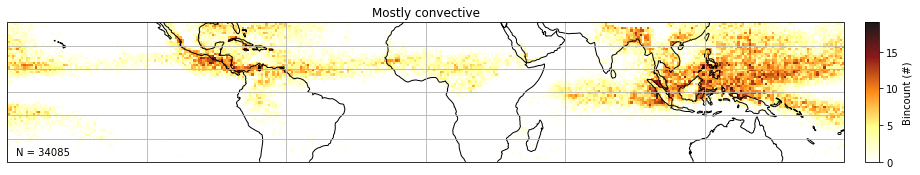

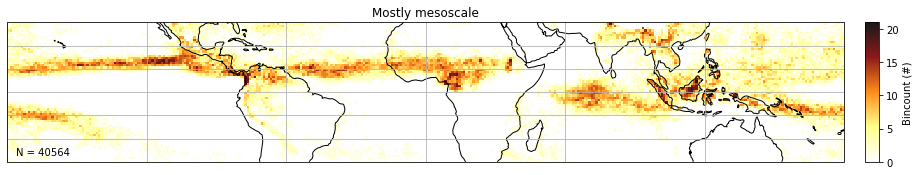

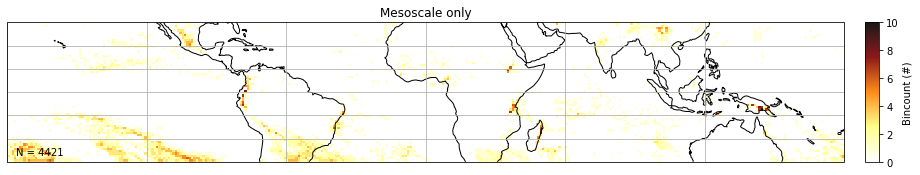

In [52]:
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

mask_all = mask_branch1_90,mask_coloc_c_90,mask_coloc_ac_90,mask_branch2_90
mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'

for mask,mask_name,mask_label in zip(mask_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_yxt = get_mask_yxt_from_mask_jdist(mask,digit3D_mean,digit3D_max)
    ax = makeMap(mask_yxt)
    ax.set_title(mask_name)
    
    plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.pdf'%(mask_label)),bbox_inches='tight')
    plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')

# MCS frequency and characteristics on the Y

In [20]:
labels_regridded = xr.open_dataset(os.path.join(path_regrid,'MCS_label.nc')).all_MCS_label
# all MCS labels in y-x-t grid
labels_regridded_yxtm = np.swapaxes(labels_regridded,axis1=2,axis2=3).values

In [172]:
# check that MCS dimension is unique # ! LONG to run
labels_unique_regridded_yxtm = np.unique(labels_regridded_yxtm,axis=3)
np.all(labels_unique_regridded_yxtm == labels_regridded_yxtm)

False

In [21]:
N_MCS = labels_regridded_yxtm.shape[3]
N_MCS

300

In [22]:
# y-x-t mask with MCS
mask_labels_regridded_yxt = np.any(~np.isnan(labels_regridded_yxtm),axis=3)

In [206]:
# fraction of tropics concerned by MCS
MCS_coverage = np.sum(mask_labels_regridded_yxt)/mask_labels_regridded_yxt.size*100
print("%s%% of the tropics gridded on 1ºx1day are partly occupied by an MCS"%("%2.1f"%MCS_coverage))

36.9% of the tropics gridded on 1ºx1day are partly occupied by an MCS


In [150]:
def labelsInMaskYXT(mask_yxt):
    """For each joint extreme in mask for joint extremes, merge MCS labels occurring in their spatiotemporal occurrence.
    LATER: also store their relative area."""

    if np.sum(mask_yxt) == 0:
        labels = labels_regridded_yxtm[False]
    else:
        labels = labels_regridded_yxtm[mask_yxt]
    unique_labels = np.unique(labels)
    
    return unique_labels
    
    
def labelsInJointBin(i_bin,j_bin):
    """For each joint extreme in bin (i,j), merge MCS labels occurring in their spatiotemporal occurrence.
    LATER: also store their relative area."""
    
    mask_yxt = get_mask_yxt(i_bin,j_bin,digit3D_mean,digit3D_max)
    # print(mask_yxt.shape)
    
    labels_i_j = labelsInMaskYXT(mask_yxt)
    
    return labels_i_j

def count_MCS_in_jdist(jdist):
    """Return matrix of MCS counts in each bin of the joint distribution"""
    
    N_i,N_j = jdist.bincount.shape
    count_ij = np.full((N_i,N_j),np.nan)
    
    for i_bin in range(N_i):
        for j_bin in range(N_j):
            
            # print(i_bin,j_bin)
            labels_bin = labelsInJointBin(i_bin,j_bin)
            labels_unique_bin = np.unique(labels_bin)
            count_ij[i_bin,j_bin] = labels_unique_bin.size
    
    return count_ij

def get_mask_yxt_labels(labels):
    """mask where these labels occur in x-y-t space"""

    mask_all_labels = False
    for label in labels:
        
        mask_label = (labels_regridded_yxtm == label)
        mask_all_labels = np.logical_or(mask_all_labels,mask_label)
        
    return mask_all_labels
    

def get_MCS_bin_fraction_in_jdist(jdist):
    
    N_i,N_j = jdist.bincount.shape
    bin_fraction_MCS = np.full((N_i,N_j),np.nan)
    bin_noise = np.full((N_i,N_j),np.nan)
    
    for i_bin in range(N_i):
        for j_bin in range(N_j):
    
            # where bin falls in x-y-t
            mask_bin_yxt = get_mask_yxt(i_bin,j_bin,digit3D_mean,digit3D_max)
        
            # where bin falls in x-y-t and MCS occurs
            mask_bin_withMCS_yxt = np.logical_and(mask_bin_yxt,mask_labels_regridded_yxt)
            
            # number of points in joint mask
            count_bin_MCS = np.sum(mask_bin_withMCS_yxt)
            
            # number of point in bin mask
            count_bin = np.sum(mask_bin_yxt)
            
            # store this fraction
            if count_bin >= 4:
                bin_fraction_MCS[i_bin,j_bin] = count_bin_MCS/count_bin
            elif count_bin > 0:
                bin_noise[i_bin,j_bin] = 1
            # include noisy points in bin_fraction_MCS
            # if count_bin > 0:
            #     bin_fraction_MCS[i_bin,j_bin] = count_bin_MCS/count_bin
            #     if count_bin <= 4:
            #         bin_noise[i_bin,j_bin] = 1
    
    # return this fraction
    return bin_fraction_MCS, bin_noise

In [151]:
# COMPUTE fraction of bin where at least 1 MCS is observed
MCS_bin_fraction_jdist, bin_noise = get_MCS_bin_fraction_in_jdist(jdist_prec)

/Users/bfildier/Code/analyses/explore-multiscale-extremes/functions/fcns_multiscale_extremes.py:11: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


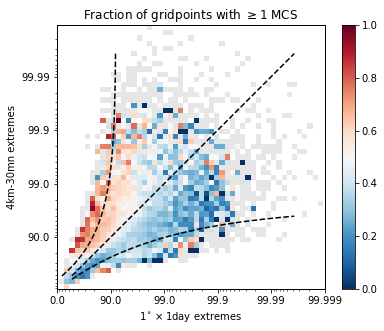

In [585]:
# SHOW fraction of bin where at least 1 MCS is observed

Z_nd = jdist_prec.norm_density.T
Z = MCS_bin_fraction_jdist.T
Z_noise = bin_noise.T

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

title = r'Fraction of gridpoints with $\geq$1 MCS'
scale ='linear'
vbds = (0., 1.)
# cmap = plt.cm.viridis
cmap = plt.cm.RdBu_r
# cmap = plt.cm.hot

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
ax.set_title(title)

# -- Conditional mean values
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    showJointHistogram(ax_show, Z_noise, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap='gray_r',alpha=0.1)


# -- Branches
cont = measure.find_contours(Z_nd, 1)    
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

# show 1-1 line
ax_show.plot(x_branch_2,x_branch_2,'k--')

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('')

plt.savefig(os.path.join(figdir,'MCS_bin_fraction_on_max_vs_mean_prec_extremes.png'),dpi=200,bbox_inches='tight')

In [167]:
# COMPUTE average number of MCS in bin
count_MCS_jdist = count_MCS_in_jdist(jdist_prec)

<ipython-input-580-4788b038fdfe>:5: RuntimeWarning: divide by zero encountered in true_divide
  Z = (count_MCS_jdist/jdist_prec.bincount).T
<ipython-input-580-4788b038fdfe>:5: RuntimeWarning: invalid value encountered in true_divide
  Z = (count_MCS_jdist/jdist_prec.bincount).T
/Users/bfildier/Code/analyses/explore-multiscale-extremes/functions/fcns_multiscale_extremes.py:11: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


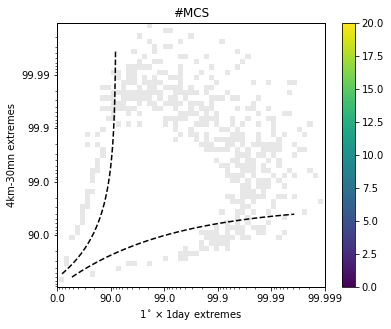

In [580]:
# SHOW average number of MCS in bin

Z_nd = jdist_prec.norm_density.T
Z_noise = bin_noise.T
Z = (count_MCS_jdist/jdist_prec.bincount).T
Z[~np.isnan(Z_noise)] = np.nan

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

title = '#MCS'
scale ='linear'
vbds = (0,20)
cmap = plt.cm.viridis
# cmap = plt.cm.hot

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
ax.set_title(title)

# -- Conditional mean values
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    showJointHistogram(ax_show, Z_noise, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap='gray',alpha=0.1)


# -- Branches
cont = measure.find_contours(Z_nd, 1)    
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('')

plt.savefig(os.path.join(figdir,'MCS_count_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')

## Conditional MCS TOOCAN properties on the Y

In [49]:
from load_TOOCAN_DYAMOND_modif_BF import *

In [50]:
DIR_TOOCAN_DYAMOND

'/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking'

In [53]:
paths_TOOCAN = glob.glob(os.path.join(DIR_TOOCAN_DYAMOND,'*.gz'))
paths_TOOCAN

['/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz',
 '/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz']

In [54]:
toocan_1 = load_TOOCAN_DYAMOND(paths_TOOCAN[0])

/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz


In [55]:
toocan_2 = load_TOOCAN_DYAMOND(paths_TOOCAN[1])

/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz


In [56]:
toocan = toocan_1+toocan_2

In [57]:
toocan[1000]

< MCS_IntParameters object:
 . label: 290331
 . qc_MCS: 11101
 . duration: 24.5
 . classif: 3
 . Tmax: 0.0
 . Utime_Init: 17045.03
 . lonInit: 158.76
 . latInit: 25.19
 . Utime_End: 17046.03
 . lonEnd: 160.74
 . latEnd: 26.79
 . lonmin: 158.76
 . latmin: 24.85
 . lonmax: 160.74
 . latmax: 27.08
 . vavg: 3.01
 . dist: 265.42
 . olrmin: 197.0
 . surfmaxPix_172Wm2: 0
 . surfmaxkm2_172Wm2: 24320.0
 . surfmaxkm2_132Wm2: 16544.0
 . surfmaxkm2_110Wm2: 12464.0
 . surfmaxkm2_90Wm2: 1936.0
 . surfcumkm2_172Wm2: 443728.0
 . surfcumkm2_132Wm2: 0
 . surfcumkm2_110Wm2: 0
 . surfcumkm2_90Wm2: 0
 . precip_total: 0
 . precip_max: 0
 . maxSurf00mmh_km2: 0
 . maxSurf02mmh_km2: 0
 . maxSurf05mmh_km2: 0
 . maxSurf10mmh_km2: 0
 . classif_JIRAK: 0.0
 . localtime_Init: 17045.4827
 . localtime_End: 17046.4882
 . clusters: <class 'load_TOOCAN_DYAMOND_modif_BF.MCS_Lifecycle'>
 >

In [322]:
np.where(np.in1d(labels_toocan,np.arange(np.max(labels_toocan))))[0]

0

In [419]:
# def computeIndicesOfLabels(labels):
#     " assumes labels are in order but not all integers are there"

#     # target with missing integers
#     target = labels
#     print(target)
#     # baseline index array
#     max_label = np.max(target)
#     all_n = np.arange(max_label+1)
#     n_target = len(target)
#     print(max_label,n_target)
#     # replace baseline index array with nans where not in target
#     target_with_nans = np.where(np.in1d(all_n,target,assume_unique=True),all_n,np.nan) 
#     # (INCLUDE assume_unique to remove MCS with the same label, but TO DEBUG )
#     # print(target_with_nans)
#     print(np.sum(~np.isnan(target_with_nans)))
#     # re_number with 
#     target_with_nans[~np.isnan(target_with_nans)] = np.arange(n_target,dtype=int)

#     return target_with_nans

In [421]:
# DEBUG: ISSUE WITH toocan[680:682] : SAME LABEL FOR TWO DIFFERENT MCSs

In [426]:
# # list of TOOCAN labels
# labels_toocan = [toocan[i].label for i in range(len(toocan))]
# labels_toocan_unique = np.unique(labels_toocan).astype(int)# TO BYPASS BUG WITH DUPLICATES
# # indices of these labels
# inds_labels_toocan = computeIndicesOfLabels(labels_toocan_unique).astype(int)
# print(inds_labels_toocan[3000])

# # NOW, given a tuple of labels lab_tup, I just need to loop through indices np.take(inds_labels_toocan,lab_tup)
# lab_tup = 3000,3004,3005
# for i_MCS in np.take(inds_labels_toocan,lab_tup):
#     print(i_MCS,toocan[i_MCS])

In [310]:
i_ex = np.where(np.in1d(labels_toocan,[3000,30004,30005]))[0]
print(i_ex)
np.take(labels_toocan,i_ex)

[ 2872 28633 28634]


array([ 3000, 30004, 30005])

In [71]:
# list of TOOCAN labels, for quicker mapping on toocan list
labels_toocan = [toocan[i].label for i in range(len(toocan))]

In [72]:
def get_labels_in_jdist_bins(jdist):
    """Return matrix N_i,N_j,N_MCS of labels in each bin of the joint distribution"""
    
    N_i,N_j = jdist.bincount.shape
    labels_ij = np.full((N_i,N_j,N_MCS),np.nan)
    
    for i_bin in range(N_i):
        for j_bin in range(N_j):
            
            # print(i_bin,j_bin)
            labels_bin = np.unique(labelsInJointBin(i_bin,j_bin))
            # number of labels
            N_labs = len(labels_bin)
            N_store = min(N_MCS,N_labs)
            # store
            labels_ij[i_bin,j_bin,:N_store] = labels_bin[:N_store]
            
    return labels_ij

In [75]:
# mapping between joint distribution bins and toocan labels
labels_in_jdist = get_labels_in_jdist_bins(jdist_prec)

In [451]:
labels_toocan[1100:1110]
np.where(np.in1d(labels_toocan,labels_toocan[1100:1110]))[0]

array([1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109])

In [548]:
toocan[3000]

< MCS_IntParameters object:
 . label: 3144
 . qc_MCS: 11101
 . duration: 10.5
 . classif: 2
 . Tmax: 0.0
 . Utime_Init: 17015.02
 . lonInit: 223.86
 . latInit: 1.64
 . Utime_End: 17015.22
 . lonEnd: 222.38
 . latEnd: 0.02
 . lonmin: 222.35
 . latmin: 0.02
 . lonmax: 223.87
 . latmax: 1.64
 . vavg: 6.45
 . dist: 243.64
 . olrmin: 198.0
 . surfmaxPix_172Wm2: 0
 . surfmaxkm2_172Wm2: 8784.0
 . surfmaxkm2_132Wm2: 4832.0
 . surfmaxkm2_110Wm2: 2608.0
 . surfmaxkm2_90Wm2: 128.0
 . surfcumkm2_172Wm2: 91920.0
 . surfcumkm2_132Wm2: 0
 . surfcumkm2_110Wm2: 0
 . surfcumkm2_90Wm2: 0
 . precip_total: 0
 . precip_max: 0
 . maxSurf00mmh_km2: 0
 . maxSurf02mmh_km2: 0
 . maxSurf05mmh_km2: 0
 . maxSurf10mmh_km2: 0
 . classif_JIRAK: 0.0
 . localtime_Init: 17014.6427
 . localtime_End: 17015.0552
 . clusters: <class 'load_TOOCAN_DYAMOND_modif_BF.MCS_Lifecycle'>
 >

In [547]:
toocan[3000].clusters

< MCS_Lifecycle object:
 . qc_im: <class 'list'>
 . olrmin: <class 'list'>
 . olravg_172Wm2: <class 'list'>
 . olravg_110Wm2: <class 'list'>
 . olravg_90Wm2: <class 'list'>
 . olr_90th: <class 'list'>
 . surfPix_172Wm2: <class 'list'>
 . surfPix_110Wm2: <class 'list'>
 . surfKm2: []
 . Utime: <class 'list'>
 . Localtime: <class 'list'>
 . lon: <class 'list'>
 . lat: <class 'list'>
 . x: <class 'list'>
 . y: <class 'list'>
 . velocity: <class 'list'>
 . semiminor_132Wm2: <class 'list'>
 . semimajor_132Wm2: <class 'list'>
 . orientation_132Wm2: <class 'list'>
 . excentricity_132Wm2: <class 'list'>
 . semiminor_172Wm2: <class 'list'>
 . semimajor_172Wm2: <class 'list'>
 . orientation_172Wm2: <class 'list'>
 . excentricity_172Wm2: <class 'list'>
 . surfkm2_172Wm2: <class 'list'>
 . surfkm2_132Wm2: <class 'list'>
 . surfkm2_110Wm2: <class 'list'>
 . surfkm2_90Wm2: <class 'list'>
 >

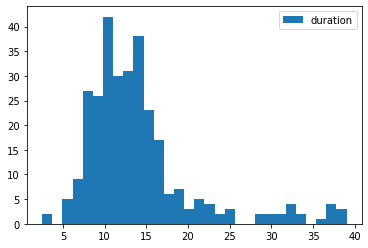

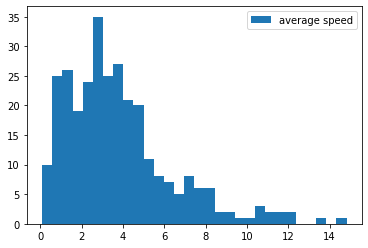

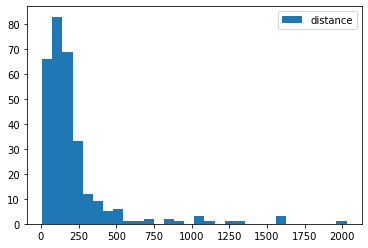

In [532]:
plt.figure()
plt.hist([toocan[i].duration for i in range(N_MCS)],bins=30,label='duration')
plt.legend()
plt.figure()
plt.hist([toocan[i].vavg for i in range(N_MCS)],bins=30,label='average speed')
plt.legend()
plt.figure()
plt.hist([toocan[i].dist for i in range(N_MCS)],bins=30,label='distance')
plt.legend()

In [504]:
for i,a in enumerate(list([30,2,105])):
    
    print(i,a)

0 30
1 2
2 105


In [506]:
# condition toocan attribute onto the Y
def condition_TOOCAN_on_jdist(attributes,jdist,func='mean'):
    """Compute conditional mean or std of TOOCAN attribute on the joint distribution"""
    
    N_i,N_j = jdist.bincount.shape
    if attributes.__class__ is not list:
        attributes = list(attributes)
    if func.__class__ is not list:
        func = list(func)
        
    N_attr = len(attributes)
    N_func = len(func)
    out_ij = np.full((N_attr,N_func,N_i,N_j),np.nan)
    keys = []
    
    for i_bin in range(N_i):
        
        if i_bin%1 == 0:
            print(i_bin,end='..')
            
        for j_bin in range(N_j):
    
            labels = labels_in_jdist[i_bin,j_bin]
            labels_valid = np.unique(labels[~np.isnan(labels)])
            
            if len(labels_valid) > 1:
                ind_labels = np.where(np.in1d(labels_toocan,labels))[0]

                for i_attr,attribute in enumerate(attributes):
                    for i_func, f in enumerate(func):

                        # compute key
                        key = "%s_%s"%(attribute,f)
                        if key not in keys:
                            keys.append(key)
                            
                        # compute function
                        attr_list = [getattr(toocan[i],attribute) for i in ind_labels]
                        
                        if len(attr_list) > 0:
                            try:
                                out_ij[i_attr,i_func,i_bin,j_bin] = getattr(np,'nan%s'%f)(attr_list)
                            except ValueError:
                                print(key)
                                print(len(labels_valid))
                                print(attr_list)
                                print("Oops!  That was no valid number.  Try again...")
            
    return out_ij, keys

In [507]:
## COMPUTE ALL PROPAGATION CHARACTERISTICS AND THEIR STD

all_attributes = 'duration','dist','vavg'
all_funcs = 'mean','max','std','min'

toocan_on_jdist_arr, keys = condition_TOOCAN_on_jdist(all_attributes,jdist_prec,all_funcs)


0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..

In [522]:
# make dict
toocan_on_jdist = {}
for i_attr,attribute in enumerate(all_attributes):
    
    for i_func, f in enumerate(all_funcs):
        
        key = "%s_%s"%(attribute,f)
        arr = toocan_on_jdist_arr[i_attr,i_func]
        # save in dict
        toocan_on_jdist[key] = arr


In [568]:
# function to show 

def showPropagationOnJdist(key,toocan_dict,title=''):

    Z_nd = jdist_prec.norm_density.T
    Z = toocan_dict[key].T
    Z_noise = bin_noise.T

    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

    # title = r'Average MCS lifetime'
    if title == '':
        title = key
    scale ='linear'
    vbds = (0., np.nanpercentile(Z,95))
    cmap = plt.cm.viridis
    # cmap = plt.cm.RdBu_r
    # cmap = plt.cm.hot

    ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

    # -- Frame
    ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
    ax.set_xlabel(r"1$^\circ\times 1$day extremes")
    ax.set_ylabel(r"4km-30mn extremes")
    ax.set_title(title)

    # -- Conditional mean values
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
        showJointHistogram(ax_show, Z_noise, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap='gray_r',alpha=0.1)


    # -- Branches
    cont = measure.find_contours(Z_nd, 1)    
    N = 60
    # fit
    popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
    x_branch_2 = y_branch_1 = np.linspace(2,45,45)
    y_branch_2 = func(x_branch_2,*popt_2)
    x_branch_1 = func(y_branch_1,*popt_1)

    # show
    ax_show.plot(x_branch_1,y_branch_1,'k--')
    ax_show.plot(x_branch_2,y_branch_2,'k--')

    # show 1-1 line
    ax_show.plot(x_branch_2,x_branch_2,'k--')

    cb = fig.colorbar(pcm, ax=ax_show)
    # cb.set_label('Normalized density')
    cb.set_label('')

    plt.savefig(os.path.join(figdir,'MCS_%s_on_max_vs_mean_prec_extremes.pdf'%key),bbox_inches='tight')

In [514]:
keys

['duration_mean',
 'duration_max',
 'duration_std',
 'duration_min',
 'dist_mean',
 'dist_max',
 'dist_std',
 'dist_min',
 'vavg_mean',
 'vavg_max',
 'vavg_std',
 'vavg_min']

In [ ]:
# SHOW all propagation attributes on Y

for key in keys:
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        showPropagationOnJdist(key)
        plt.show()

/Users/bfildier/Code/analyses/explore-multiscale-extremes/functions/fcns_multiscale_extremes.py:11: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


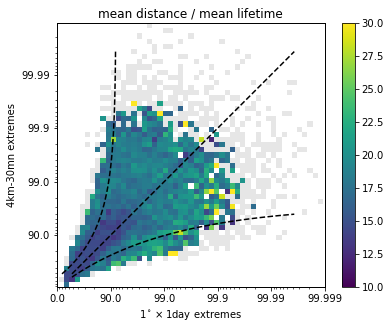

In [567]:
Z_nd = jdist_prec.norm_density.T
Z_noise = bin_noise.T
Z = (toocan_on_jdist['dist_mean']/toocan_on_jdist['duration_mean']).T
Z[~np.isnan(Z_noise)] = np.nan

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

title = r'mean distance / mean lifetime'
# if title == '':
#     title = key
scale ='linear'
vbds = (10., 30)
cmap = plt.cm.viridis
# cmap = plt.cm.RdBu_r
# cmap = plt.cm.hot

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
ax.set_title(title)

# -- Conditional mean values
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    showJointHistogram(ax_show, Z_noise, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap='gray',alpha=0.1)


# -- Branches
cont = measure.find_contours(Z_nd, 1)    
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

# show 1-1 line
ax_show.plot(x_branch_2,x_branch_2,'k--')

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('')

plt.savefig(os.path.join(figdir,'MCS_distance_over_duration_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')

In [545]:
# compute percentiles (interquartile range for instance)

# condition toocan attribute onto the Y
def condition_percentile_TOOCAN_on_jdist(attributes,jdist,perc=50):
    """Compute conditional mean or std of TOOCAN attribute on the joint distribution"""
    
    N_i,N_j = jdist.bincount.shape
    if attributes.__class__ is not list:
        attributes = list(attributes)
    if perc.__class__ is not list:
        perc = list(perc)
        print(perc)
        
    N_attr = len(attributes)
    N_perc = len(perc)
    out_ij = np.full((N_attr,N_perc,N_i,N_j),np.nan)
    keys = []
    
    for i_bin in range(N_i):
        
        if i_bin%1 == 0:
            print(i_bin,end='..')
            
        for j_bin in range(N_j):
    
            labels = labels_in_jdist[i_bin,j_bin]
            labels_valid = np.unique(labels[~np.isnan(labels)])
            
            if len(labels_valid) > 1:
                ind_labels = np.where(np.in1d(labels_toocan,labels))[0]

                for i_attr,attribute in enumerate(attributes):
                    for i_perc, p in enumerate(perc):

                        # compute key
                        key = "%s_%d"%(attribute,p)
                        if key not in keys:
                            print('add key',key)
                            keys.append(key)
                            
                        # compute function
                        attr_list = [getattr(toocan[i],attribute) for i in ind_labels]
                        
                        if len(attr_list) > 0:
                            try:
                                out_ij[i_attr,i_perc,i_bin,j_bin] = np.nanpercentile(attr_list,p)
                            except ValueError:
                                print(key)
                                print(len(labels_valid))
                                print(attr_list)
                                print("Oops!  That was no valid number.  Try again...")
            
    return out_ij, keys

In [546]:
## COMPUTE ALL PROPAGATION CHARACTERISTICS AND THEIR STD

all_attributes = 'duration','dist','vavg'
all_percs = 10,25,50,75,90

toocan_perc_on_jdist_arr, keys = condition_percentile_TOOCAN_on_jdist(all_attributes,jdist_prec,all_percs)


[10, 25, 50, 75, 90]
0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..

In [554]:
# make dict
toocan_perc_on_jdist = {}
for i_attr,attribute in enumerate(all_attributes):
    
    for i_perc, p in enumerate(all_percs):
        
        key = "%s_%s"%(attribute,p)
        arr = toocan_perc_on_jdist_arr[i_attr,i_perc]
        # save in dict
        toocan_perc_on_jdist[key] = arr


In [ ]:
# SHOW percentiles of propagation attributes on Y

for key in toocan_perc_on_jdist.keys():
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        showPropagationOnJdist(key,toocan_perc_on_jdist)
        plt.show()

In [570]:
len(toocan)

347106

In [573]:
np.prod(prec_data.mean_Prec.shape)

475200

### Condition TOOCAN attribute(time)

In [146]:
# condition toocan attribute onto the Y
def condition_TOOCAN_on_jdist(attributes,jdist,func='mean'):
    """Compute conditional mean or std of TOOCAN attribute on the joint distribution"""
    
    N_i,N_j = jdist.bincount.shape
    if attributes.__class__ is str:
        attributes = [attributes]
    elif attributes.__class__ is not list:
        attributes = list(attributes)
    if func.__class__ is str:
        func = [func]
    elif func.__class__ is not list:
        func = list(func)
        
    N_attr = len(attributes)
    N_func = len(func)
    out_ij = np.full((N_attr,N_func,N_i,N_j),np.nan)
    keys = []
    
    for i_bin in range(N_i):
        
        if i_bin%1 == 0:
            print(i_bin,end='..')
            
        for j_bin in range(N_j):
    
            labels = labels_in_jdist[i_bin,j_bin]
            labels_valid = np.unique(labels[~np.isnan(labels)])
            
            if len(labels_valid) > 1:
                ind_labels = np.where(np.in1d(labels_toocan,labels))[0]

                for i_attr,attribute in enumerate(attributes):
                    for i_func, f in enumerate(func):

                        # compute key
                        key = "%s_%s"%(attribute,f)
                        if key not in keys:
                            keys.append(key)
                            
                        # compute function
                        if attribute in toocan[0].__dict__.keys():
                            attr_list = [getattr(toocan[i],attribute) for i in ind_labels]
                        elif attribute in toocan[0].clusters.__dict__.keys():
                            attr_list = [np.mean(getattr(toocan[i].clusters,attribute)) for i in ind_labels]
                            # print('attr_values')
                            # print(attr_values[:3])
                            # attr_n = [len(attr_values[i]) for i in range(len(attr_values))]
                            # print('attr_n')
                            # attr_ind = [int((attr_n[i]-1)*0.3) for i in range(len(attr_n))]
                            # attr_list = [np.mean(attr_values[i]) for i in range(len(attr_n))]
                        
                        if len(attr_list) > 0:
                            try:
                                out_ij[i_attr,i_func,i_bin,j_bin] = getattr(np,'nan%s'%f)(attr_list)
                            except ValueError:
                                print(key)
                                print(len(labels_valid))
                                print(attr_list)
                                print("Oops!  That was no valid number.  Try again...")
            
    return out_ij, keys

In [147]:
excentricity = condition_TOOCAN_on_jdist('excentricity_172Wm2',jdist_prec,func='mean')

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..

In [148]:
Amax = condition_TOOCAN_on_jdist('surfmaxkm2_172Wm2',jdist_prec,func='mean')

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..

In [156]:
excentricity[0][0,0].T.shape

(51, 51)

/home/bfildier/analyses/explore-multiscale-extremes/functions/fcns_multiscale_extremes.py:11: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a mask

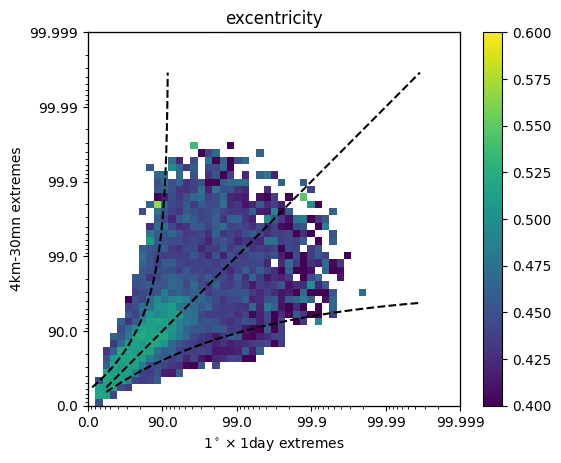

In [162]:
## SHOW 

Z_nd = jdist_prec.norm_density.T
Z_noise = bin_noise.T
Z = excentricity[0][0,0].T
Z[~np.isnan(Z_noise)] = np.nan

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

title = r'excentricity'
# if title == '':
#     title = key
scale ='linear'
vbds = (0.4, 0.6)
cmap = plt.cm.viridis
# cmap = plt.cm.RdBu_r
# cmap = plt.cm.hot

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
ax.set_title(title)

# -- Conditional mean values
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    showJointHistogram(ax_show, Z_noise, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap='gray',alpha=0.1)


# -- Branches
cont = measure.find_contours(Z_nd, 1)    
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

# show 1-1 line
ax_show.plot(x_branch_2,x_branch_2,'k--')

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('')

plt.savefig(os.path.join(figdir,'MCS_excentricity_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()

/home/bfildier/analyses/explore-multiscale-extremes/functions/fcns_multiscale_extremes.py:11: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a mask

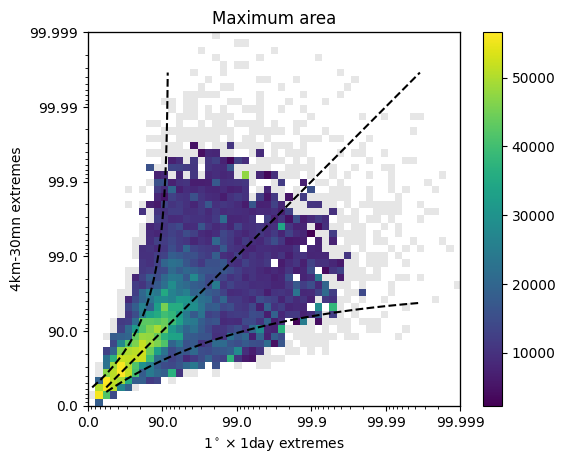

In [164]:
## SHOW 

Z_nd = jdist_prec.norm_density.T
Z_noise = bin_noise.T
Z = Amax[0][0,0].T
Z[~np.isnan(Z_noise)] = np.nan

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

title = r'Maximum area'
# if title == '':
#     title = key
scale ='linear'
vbds = (None, None)
cmap = plt.cm.viridis
# cmap = plt.cm.RdBu_r
# cmap = plt.cm.hot

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# -- Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
ax.set_title(title)

# -- Conditional mean values
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    showJointHistogram(ax_show, Z_noise, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap='gray',alpha=0.1)


# -- Branches
cont = measure.find_contours(Z_nd, 1)    
N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

# show 1-1 line
ax_show.plot(x_branch_2,x_branch_2,'k--')

cb = fig.colorbar(pcm, ax=ax_show)
# cb.set_label('Normalized density')
cb.set_label('')

plt.savefig(os.path.join(figdir,'MCS_Amax_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()

# Environment variables on the Y

In [27]:
##--- MCS mask

labels_regridded = xr.open_dataset(os.path.join(path_regrid,'MCS_label.nc')).all_MCS_label
# all MCS labels in y-x-t grid
labels_regridded_yxtm = np.swapaxes(labels_regridded,axis1=2,axis2=3).values
# number of MCS
N_MCS = labels_regridded_yxtm.shape[3]
# y-x-t mask with MCS
mask_labels_regridded_yxt = np.any(~np.isnan(labels_regridded_yxtm),axis=3)

In [23]:
LLS_data = xr.open_dataset(os.path.join(path_regrid,'LLS.nc'))['mean_LLS']

In [25]:
def compute_conditional_data_with_mask(sample1,sample2,data,mask,jdist):
    
    sample1_masked = sample1[mask].flatten()
    sample2_masked = sample2[mask].flatten()
    data_masked = data[mask].flatten()
    cond_data = jdist.computeConditionalDataOverDensity(sample1=sample1_masked,
                                                        sample2=sample2_masked,
                                                        data=data_masked)
    return cond_data

In [33]:
cvarid = 'LLS'
cond_data_mean = xr.open_dataset(os.path.join(path_regrid,'%s.nc'%cvarid))['mean_%s'%cvarid].values
mask = mask_labels_regridded_yxt
# print(cond_data_mean.__class__,mask.__class__)
ex_cond_var = compute_conditional_data_with_mask(mean_prec,max_prec,cond_data_mean,mask,jdist_prec)

/home/bfildier/analyses/explore-multiscale-extremes/modules/conditionalstats.py:932: RuntimeWarning: Mean of empty slice
  data_over_density[i1, i2] = np.nanmean(data.flatten()[data_idx])


In [37]:
cond_varids = 'CWP', 'IWP', 'LHF', 'LLS', 'LLSU', 'LLSV', 'OM850', 'Prec', 'PW', 'RH500', 'RH850', 'SHF', 'T2mm', 'U10m', 'V10m'

cond_dict = dict()
s1 = mean_prec
s2 = max_prec
mask = mask_labels_regridded_yxt
jdist = jdist_prec

for cvarid in cond_varids:
    
    cond_dict[cvarid] = {}
    
    print(cvarid)
    cond_data_mean = xr.open_dataset(os.path.join(path_regrid,'%s.nc'%cvarid))['mean_%s'%cvarid].values
    cond_data_max = xr.open_dataset(os.path.join(path_regrid,'%s.nc'%cvarid))['max_%s'%cvarid].values
    
    cond_dict[cvarid]['mean'] = compute_conditional_data_with_mask(s1,s2,cond_data_mean,mask,jdist)
    cond_dict[cvarid]['max'] = compute_conditional_data_with_mask(s1,s2,cond_data_max,mask,jdist)
    cond_dict[cvarid]['units'] = None
    
    # clear memory
    del cond_data_mean, cond_data_max
    gc.collect()
    

CWP


/home/bfildier/analyses/explore-multiscale-extremes/modules/conditionalstats.py:932: RuntimeWarning: Mean of empty slice
  data_over_density[i1, i2] = np.nanmean(data.flatten()[data_idx])


IWP
LHF
LLS
LLSU
LLSV
OM850
Prec
PW
RH500
RH850
SHF
T2mm
U10m
V10m


In [ ]:
# Show conditional values

for cvarid in cond_varids:
    
    for func in 'mean','max':
    
        Z_nd = jdist_prec.norm_density.T
        Z = cond_dict[cvarid][func].T

        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

        title = '%s'%cvarid
        scale ='linear'
        vbds = (None, None)
        cmap = plt.cm.viridis

        ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

        # -- Frame
        ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
        ax.set_xlabel(r"1$^\circ\times 1$day extremes")
        ax.set_ylabel(r"4km-30mn extremes")
        ax.set_title(title)

        # -- Conditional mean values
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)


        # -- Branches
        cont = measure.find_contours(Z_nd, 1)    
        N = 60
        # fit
        popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
        x_branch_2 = y_branch_1 = np.linspace(2,45,45)
        y_branch_2 = func(x_branch_2,*popt_2)
        x_branch_1 = func(y_branch_1,*popt_1)

        # show
        ax_show.plot(x_branch_1,y_branch_1,'k--')
        ax_show.plot(x_branch_2,y_branch_2,'k--')

        cb = fig.colorbar(pcm, ax=ax_show)
        # cb.set_label('Normalized density')
        cb.set_label('')

        plt.savefig(os.path.join(figdir,'%s_%s_whereMCS_on_max_vs_mean_prec_extremes.pdf'%(cvarid,func)),bbox_inches='tight')
        plt.close()

# LANDMASK

In [68]:
# LANDMASK - distribution of land, distribution of ocean separately

cvarid = 'LANDMASK'

# landmask data
landmask_rg = xr.open_dataset(os.path.join(path_regrid,'%s.nc'%cvarid))['mean_%s'%cvarid]
island = landmask_rg > 0.5
isocean = landmask_rg < 0.5
Nland = np.sum(island).values
Nocean = np.sum(isocean).values
Ntot = np.size(island)

# Count
bincount_land = jdist_prec.computeConditionalSum(sample1=mean_prec,sample2=max_prec,data=island.values)
bincount_ocean = jdist_prec.computeConditionalSum(sample1=mean_prec,sample2=max_prec,data=isocean.values)


In [69]:
Nland, Nocean, Ntot, Nland+Nocean

(array(121198), array(354002), 475200, 475200)

/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


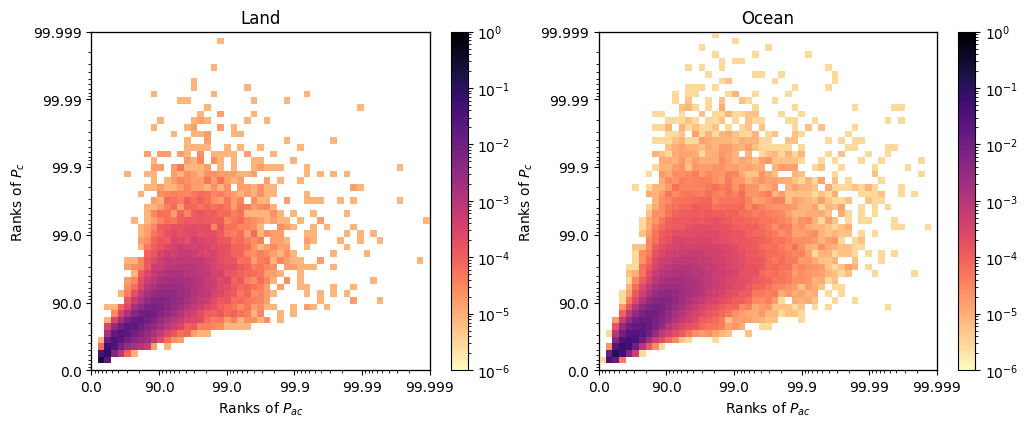

In [65]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4.4))

Z1 = bincount_land.T/Nland
Z2 = bincount_ocean.T/Nocean

titles = 'Land', 'Ocean'
scales = 'log','log'
vbounds = (1e-6,1),(1e-6,1)
cmaps = plt.cm.magma_r, plt.cm.magma_r

for ax,Z,title,scale,vbds,cmap in zip(axs,(Z1,Z2),titles,scales,vbounds,cmaps):

    ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

    # Frame
    ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
    ax.set_xlabel("Ranks of $P_{ac}$")
    ax.set_ylabel("Ranks of $P_{c}$")
    ax.set_title(title)

    # Content
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    
    fig.colorbar(pcm, ax=ax_show)
    
plt.savefig(os.path.join(figdir,'number_over_land_and_ocean_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()

/tmp/ipykernel_3105530/979033929.py:3: RuntimeWarning: divide by zero encountered in true_divide
  Z1 = bincount_land.T/Nland / (jdist_prec.bincount.T/Ntot)
/tmp/ipykernel_3105530/979033929.py:3: RuntimeWarning: invalid value encountered in true_divide
  Z1 = bincount_land.T/Nland / (jdist_prec.bincount.T/Ntot)
/tmp/ipykernel_3105530/979033929.py:4: RuntimeWarning: divide by zero encountered in true_divide
  Z2 = bincount_ocean.T/Nocean / (jdist_prec.bincount.T/Ntot)
/tmp/ipykernel_3105530/979033929.py:4: RuntimeWarning: invalid value encountered in true_divide
  Z2 = bincount_ocean.T/Nocean / (jdist_prec.bincount.T/Ntot)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildi

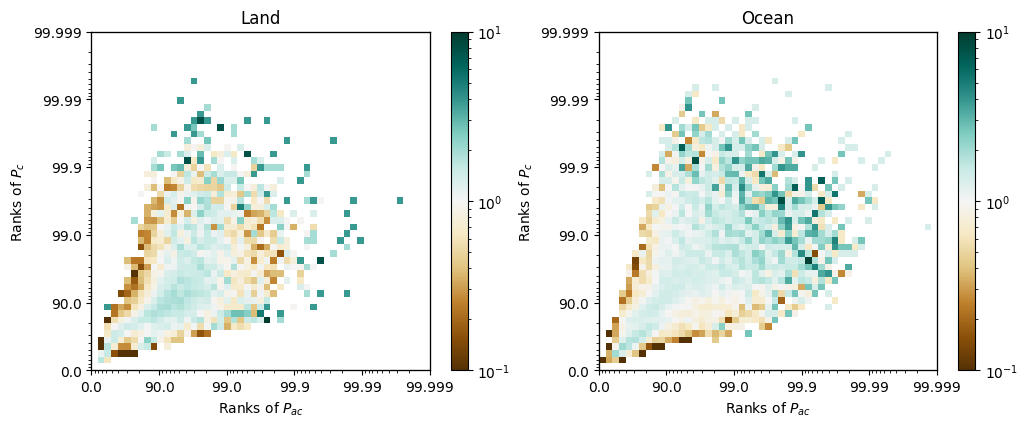

In [70]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4.4))

Z1 = bincount_land.T/Nland / (jdist_prec.bincount.T/Ntot)
Z2 = bincount_ocean.T/Nocean / (jdist_prec.bincount.T/Ntot)

titles = 'Land', 'Ocean'
scales = 'log','log'
# vbounds = (1,1e4),(1e-3,1e3)
vbounds = (1e-1,1e1),(1e-1,1e1)
# cmaps = plt.cm.magma_r, plt.cm.magma_r
cmaps = plt.cm.BrBG, plt.cm.BrBG

for ax,Z,title,scale,vbds,cmap in zip(axs,(Z1,Z2),titles,scales,vbounds,cmaps):

    ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

    # Frame
    ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
    ax.set_xlabel("Ranks of $P_{ac}$")
    ax.set_ylabel("Ranks of $P_{c}$")
    ax.set_title(title)

    # Content
    pcm = showJointHistogram(ax_show, Z, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    
    fig.colorbar(pcm, ax=ax_show)
    
plt.savefig(os.path.join(figdir,'fraction_over_land_and_ocean_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()

## Best figure

In [77]:
def fitBranches(cont,N):

    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
    
    if cont.__class__ is list:
        seg_1 = np.flip(cont[0],axis=1)
    else:
        seg_1 = cont.allsegs[0][0]
        
    # Branch 1 -- end of contour (upward branch)
    xdata_1 = seg_1[-N:,0]
    y_1 = ydata_1 = seg_1[-N:,1]

    # fit
    popt_1, pcov_1 = curve_fit(func, ydata_1, xdata_1,p0=(-10,1,0))
    x_1 = func(ydata_1, *popt_1)
    
    # Branch 2 -- start of contour
    x_2 = xdata_2 = seg_1[:N,0]
    ydata_2 = seg_1[:N,1]

    # fit
    popt_2, pcov_2 = curve_fit(func, xdata_2, ydata_2,p0=(-10,1,0))
    y_2 = func(xdata_2, *popt_2)
    
    return popt_1, x_1, y_1, popt_2, x_2, y_2, func

/tmp/ipykernel_3105530/3639958950.py:5: RuntimeWarning: divide by zero encountered in true_divide
  Z_show = Z2/Z1
/tmp/ipykernel_3105530/3639958950.py:5: RuntimeWarning: invalid value encountered in true_divide
  Z_show = Z2/Z1
/tmp/ipykernel_3105530/3932774558.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/bfildier/.local/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  

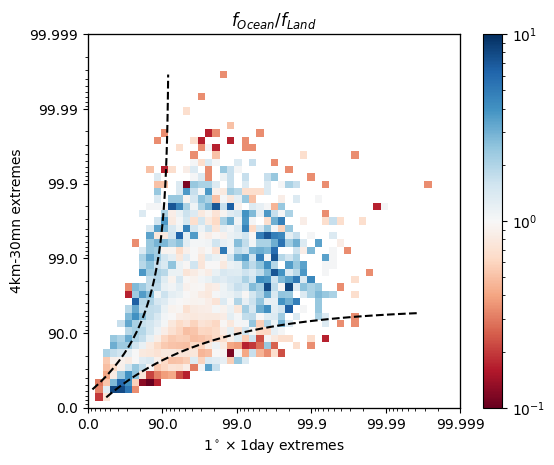

In [90]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4.85))

Z1 = bincount_land.T/Nland
Z2 = bincount_ocean.T/Nocean
Z_show = Z2/Z1
Z = jdist_prec.norm_density.T

title = r'$f_{Ocean}/f_{Land}$'
scale = 'log'
vbds = (1e-1,1e1)
cmap = plt.cm.RdBu

ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

# Frame
ax = setFrameIL(ax, dist_mean_prec.ranks, dist_max_prec.ranks)
ax.set_xlabel(r"1$^\circ\times 1$day extremes")
ax.set_ylabel(r"4km-30mn extremes")
ax.set_title(title)

# Content
pcm = showJointHistogram(ax_show, Z_show, scale=scale, vmin=vbds[0], vmax=vbds[1], cmap=cmap)
    
# -- Branches

cont = measure.find_contours(Z, 1)

N = 60
# fit
popt_1, x_1, y_1, popt_2, x_2, y_2, func = fitBranches(cont,N)
x_branch_2 = y_branch_1 = np.linspace(2,45,45)
y_branch_2 = func(x_branch_2,*popt_2)
x_branch_1 = func(y_branch_1,*popt_1)

# show
ax_show.plot(x_branch_1,y_branch_1,'k--')
ax_show.plot(x_branch_2,y_branch_2,'k--')

fig.colorbar(pcm, ax=ax_show)
    
plt.savefig(os.path.join(figdir,'ratio_flocean_fland_on_max_vs_mean_prec_extremes.pdf'),bbox_inches='tight')
plt.show()

## REDO LLS with correct vmax and masking noise